In [126]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import pywt
%matplotlib inline

# Data Preprocessing

In [173]:
face_cascade = cv2.CascadeClassifier('opencv/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('opencv/haarcascade_eye.xml')


In [174]:
def crop_img_2eye(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >=2:
            return roi_color
            

In [175]:
path_to_data = "./data/"
path_to_cr_data = "./data/cropped/"


import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [176]:
img_dirs

['./data/lionel_messi',
 './data/maria_sharapova',
 './data/roger_federer',
 './data/serena_williams',
 './data/virat_kohli']

In [177]:

import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)



In [178]:

cropped_image_dirs = []
for img_dir in img_dirs:
#     print(img_dir)
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    for entry in os.scandir(img_dir):
#         print(entry.path)
        try:
            roi_color = crop_img_2eye(entry.path)
        except:
            continue
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            count += 1

Generating cropped images in folder:  ./data/cropped/lionel_messi
Generating cropped images in folder:  ./data/cropped/maria_sharapova
Generating cropped images in folder:  ./data/cropped/roger_federer
Generating cropped images in folder:  ./data/cropped/serena_williams
Generating cropped images in folder:  ./data/cropped/virat_kohli


In [179]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'lionel_messi': ['./data/cropped/lionel_messi\\lionel_messi1.png',
  './data/cropped/lionel_messi\\lionel_messi10.png',
  './data/cropped/lionel_messi\\lionel_messi11.png',
  './data/cropped/lionel_messi\\lionel_messi12.png',
  './data/cropped/lionel_messi\\lionel_messi13.png',
  './data/cropped/lionel_messi\\lionel_messi14.png',
  './data/cropped/lionel_messi\\lionel_messi15.png',
  './data/cropped/lionel_messi\\lionel_messi16.png',
  './data/cropped/lionel_messi\\lionel_messi17.png',
  './data/cropped/lionel_messi\\lionel_messi18.png',
  './data/cropped/lionel_messi\\lionel_messi19.png',
  './data/cropped/lionel_messi\\lionel_messi2.png',
  './data/cropped/lionel_messi\\lionel_messi20.png',
  './data/cropped/lionel_messi\\lionel_messi21.png',
  './data/cropped/lionel_messi\\lionel_messi22.png',
  './data/cropped/lionel_messi\\lionel_messi23.png',
  './data/cropped/lionel_messi\\lionel_messi24.png',
  './data/cropped/lionel_messi\\lionel_messi25.png',
  './data/cropped/lionel_messi\\

In [180]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [181]:

import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img

    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;

    coeffs=pywt.wavedec2(imArray, mode, level=level)


    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [182]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [183]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(187, 4096)

In [184]:
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [185]:
from collections import Counter
Counter(y)

Counter({0: 39, 1: 35, 2: 30, 3: 35, 4: 48})

# Modeling

In [186]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit(X).transform(X)

In [187]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10)


In [188]:

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


## Hyper Parameter Tunning

In [189]:
scores=[]
best_estimators = {}


model_params = {  
     'LOGISTIC_REGRESSION': {
        'model': LogisticRegression(max_iter=500),
        'params': {
            'C': [1,5,10],
            'solver' : [ 'liblinear', 'lbfgs'],
            'multi_class' : ['auto', 'ovr' ]
            
            
        }
    },
    
        
    'SVM': {
        'model': SVC(),
        'params': {
             'C': [1,50,100],
             'kernel': ['rbf','linear'],
             'gamma': ['auto', 'scale']
        }
    },
       
    'RANDOM_FOREST':{
        'model' : RandomForestClassifier(),
        'params': {
            'n_estimators':[70,75,90],
            'criterion': ['entropy']

        }
    }
}

In [190]:
import time


for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    print(mp['model'], mp['params'])
    start_time = time.time()
    
    clf.fit(X_train, y_train)    
    

    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': str(clf.best_params_)
    })
    best_estimators[model_name] = clf.best_estimator_
    print('{} minutes'.format((time.time() - start_time)/60))



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) {'C': [1, 5, 10], 'solver': ['liblinear', 'lbfgs'], 'multi_class': ['auto', 'ovr']}
0.441305144627889 minutes
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) {'C': [1, 50, 100], 'kernel': ['rbf', 'linear'], 'gamma': ['auto', 'scale']}
0.092400594552358 minutes
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None

In [191]:
import pandas as pd    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df = df.sort_values(by='best_score',ascending=False)
# df.drop_duplicates(inplace=True)
df

,model,best_score,best_params
0,LOGISTIC_REGRESSION,0.771494,"{'C': 1, 'multi_class': 'auto', 'solver': 'lbf..."
1,SVM,0.737701,"{'C': 1, 'gamma': 'auto', 'kernel': 'linear'}"
2,RANDOM_FOREST,0.711034,"{'criterion': 'entropy', 'n_estimators': 70}"


 ## Evaluation

In [192]:
best_estimators['SVM'].score(X_test,y_test)

0.8421052631578947

In [193]:
best_estimators['LOGISTIC_REGRESSION'].score(X_test,y_test)

0.868421052631579

In [195]:
best_estimators['RANDOM_FOREST'].score(X_test,y_test)

0.7631578947368421

In [363]:
best_clf = best_estimators['RANDOM_FOREST']
best_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [364]:
from sklearn.metrics import classification_report
print(classification_report(y_test,best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.86      0.92         7

    accuracy                           0.96        27
   macro avg       0.98      0.93      0.95        27
weighted avg       0.96      0.96      0.96        27



In [365]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[20,  0],
       [ 1,  6]], dtype=int64)

Text(69.0, 0.5, 'Truth')

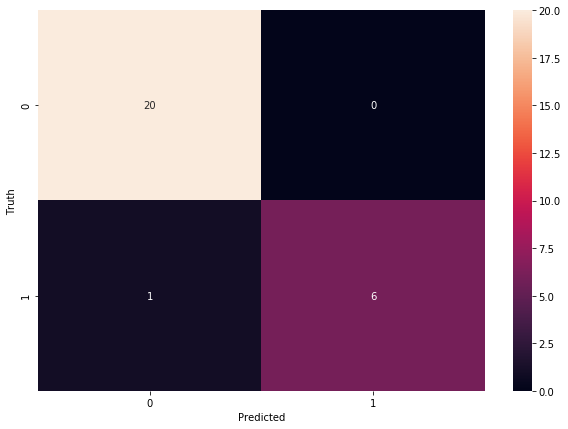

In [106]:
import seaborn as sns 
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

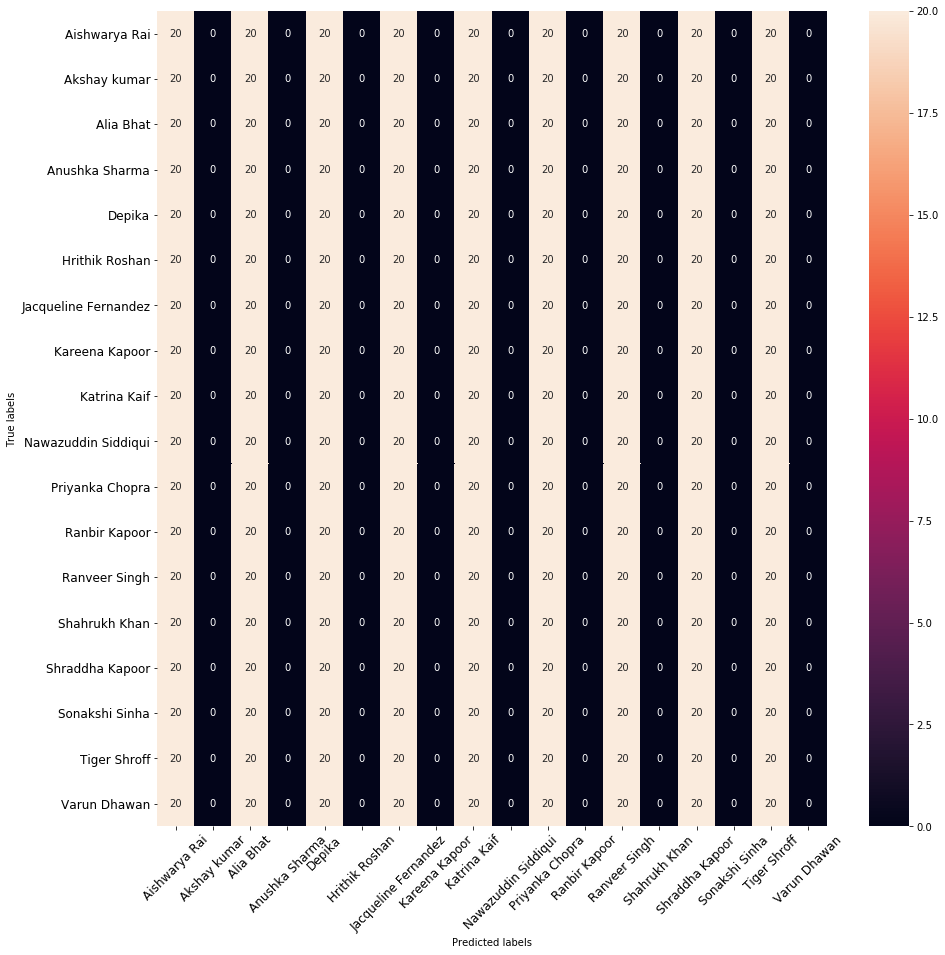

In [105]:
cm=[[20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
    [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0],
   [20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0,20,0]]
import seaborn as sns 
fig, ax = plt.subplots(figsize=(15,15))

g = sns.heatmap(cm,annot=True,ax=ax)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 12)
ax.xaxis.set_ticklabels(class_dict.keys()); ax.yaxis.set_ticklabels(class_dict.keys());
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 


In [92]:
class_dict

{'Aishwarya Rai': 0,
 'Akshay kumar': 1,
 'Alia Bhat': 2,
 'Anushka Sharma': 3,
 'Depika': 4,
 'Hrithik Roshan': 5,
 'Jacqueline Fernandez': 6,
 'Kareena Kapoor': 7,
 'Katrina Kaif': 8,
 'Nawazuddin Siddiqui': 9,
 'Priyanka Chopra': 10,
 'Ranbir Kapoor': 11,
 'Ranveer Singh': 12,
 'Shahrukh Khan': 13,
 'Shraddha Kapoor': 14,
 'Sonakshi Sinha': 15,
 'Tiger Shroff': 16,
 'Varun Dhawan': 17}

## Save Model

In [368]:
import joblib
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

## Save Class

In [370]:

import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))